<a href="https://colab.research.google.com/github/smridhii11/train_file/blob/main/hack3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Smridhi_kaur**

#**importing libraries**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

#**Loading Dataset**

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
train.fillna(train.mean(numeric_only=True), inplace=True)
test.fillna(test.mean(numeric_only=True), inplace=True)


In [ ]:
if 'feature_1' in train.columns and 'feature_2' in train.columns:
    train['f_interact'] = train['feature_1'] * train['feature_2']
    test['f_interact'] = test['feature_1'] * test['feature_2']



In [ ]:
drop_cols = [col for col in ['id', 'output'] if col in train.columns]
X = train.drop(columns=drop_cols)
y = train['output']
X_test = test.drop(columns=['id']) if 'id' in test.columns else test.copy()



In [ ]:
print("Train features:", X.shape)
print("Train target:", y.shape)
print("Test features:", X_test.shape)

Train features: (8999, 17)
Train target: (8999,)
Test features: (6001, 17)


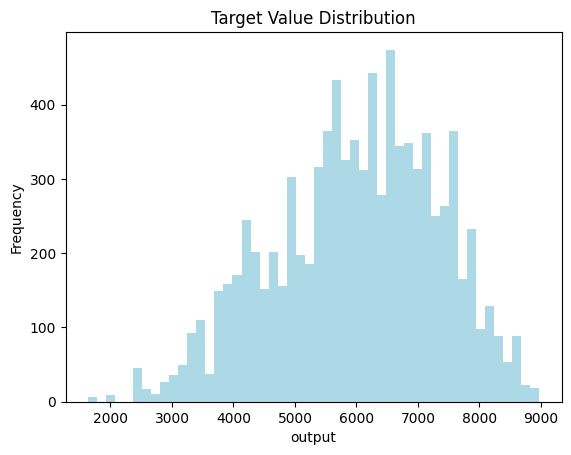

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y, bins=50, color='lightblue')
plt.title('Target Value Distribution')
plt.xlabel('output')
plt.ylabel('Frequency')
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=12, min_samples_split=3,  random_state=42)
rf_model.fit(X_train, y_train)
rf_val = rf_model.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, rf_val))
print("Random Forest RMSE:", rmse_rf)





Random Forest RMSE: 374.0318375627753


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6,
                             subsample=0.9, colsample_bytree=0.8, objective='reg:squarederror',
                             random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val = xgb_model.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, val_xgb))
print("XGB RMSE:", rmse_xgb)



XGB RMSE: 374.5412421404241


In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_val = lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(y_val, lgb_val))
print("LightGBM RMSE:", rmse_lgb)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 7199, number of used features: 17
[LightGBM] [Info] Start training from score 5995.420243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [ ]:
rf_val = rf_model.predict(X_val)
xgb_val = xgb_model.predict(X_val)
lgb_val = lgb_model.predict(X_val)

import itertools

weights = np.linspace(0, 1, 21)
best_score = float('inf')
best_combo = None

for w1, w2 in itertools.product(weights, repeat=2):
    if w1 + w2 <= 1:
        w3 = 1 - w1 - w2
        blend = w1 * rf_val + w2 * xgb_val + w3 * lgb_val
        score = np.sqrt(mean_squared_error(y_val, blend))
        if score < best_score:
            best_score = score
            best_combo = (w1, w2, w3)

print(" Best Weights (RF, XGB, LGB):", best_combo)
print(" Best RMSE:", best_score)



 Best Weights (RF, XGB, LGB): (np.float64(0.4), np.float64(0.1), np.float64(0.5))
 Best RMSE: 369.0112575483298


In [ ]:
# Apply best weights to validation predictions (optional, for graph or tracking)
w_rf, w_xgb, w_lgb = best_combo
val_blend = w_rf * rf_val + w_xgb * xgb_val + w_lgb * lgb_val
rmse_blend = np.sqrt(mean_squared_error(y_val, val_blend))

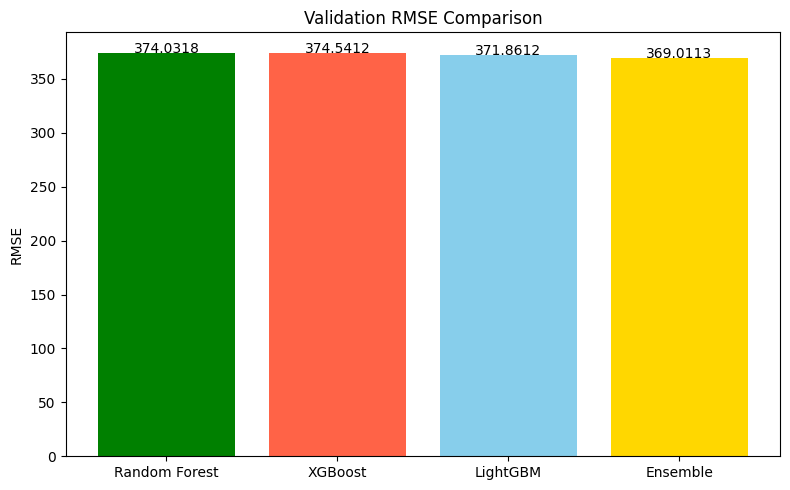

In [ ]:
models = ['Random Forest', 'XGBoost', 'LightGBM', 'Ensemble']
rmse_scores = [rmse_rf, rmse_xgb, rmse_lgb, rmse_blend]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmse_scores, color=['green', 'tomato', 'skyblue', 'gold'])
plt.title('Validation RMSE Comparison')
plt.ylabel('RMSE')
for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.4f}", ha='center')
plt.tight_layout()
plt.show()



In [ ]:
rf_test = rf_model.predict(X_test)
xgb_test = xgb_model.predict(X_test)
lgb_test = lgb_model.predict(X_test)

w_rf, w_xgb, w_lgb = best_combo
final_preds = w_rf * rf_test + w_xgb * xgb_test + w_lgb * lgb_test


# Clip only once based on real target range
clip_cap = np.percentile(y, 99.5)
final_preds = np.clip(final_preds, a_min=0, a_max=clip_cap)

print("Clipping predictions above:", clip_cap)
print("Post-clip sample:", final_preds[:5])


Clipping predictions above: 8671.71681
Post-clip sample: [4222.19134941 3439.04632365 6421.8894034  4231.98683736 7312.68568426]


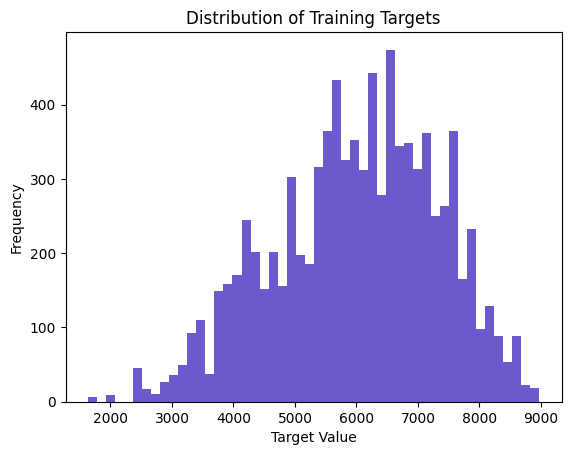

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y, bins=50, color='slateblue')
plt.title("Distribution of Training Targets")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:

clip_cap = 8671.71681
final_preds = lgb_model.predict(X_test)
final_preds = np.clip(final_preds, 0, clip_cap)
final_preds *= 0.975
final_preds = final_preds.round(2)

In [ ]:
submission = sample_submission.copy()
submission['output'] = final_preds

print("✅ Final output range:")
print("Min:", submission['output'].min())
print("Max:", submission['output'].max())
print(submission.head())

submission.to_csv('submission_super_ensemble.csv', index=False)
print("✅ Submission saved: submission_super_ensemble.csv")

✅ Final output range:
Min: 2287.03
Max: 8454.92
   id   output
0   1  4120.73
1   2  3367.07
2   3  6248.30
3   4  4123.03
4   5  7110.86
✅ Submission saved: submission_super_ensemble.csv
